In [1]:
import sys
sys.path.append('../src/')

In [2]:
import pandas as pd
import numpy as np
from talib_map import ta_map, func_map
import re
from functools import partial
from features_extraction import *
from targets_extraction import *

In [3]:
df = pd.read_csv("../data/data.csv")

In [5]:
df = prepare_desired_pos(df, 10, 10)

In [34]:
df['desired_pos_change_adj'] = df['desired_pos_change'] - df['desired_pos_change'].shift(10).fillna(0)

In [6]:
df

,symbol,exchange,datetime,open,high,low,close,volume,turnover,open_interest,desired_pos_change,pos_change_signal,desired_pos_rolling,net_pos_signal
0,SP99,CZCE,2018-11-27 09:00:00,5830.9811,5833.1616,5663.3209,5689.4757,16068.0,926916280.0,10596.0,-26,strong sell,-26,short hold
1,SP99,CZCE,2018-11-27 09:01:00,5697.0277,5754.2022,5696.4447,5742.6281,8978.0,514391440.0,13016.0,-69,strong sell,-95,short hold
2,SP99,CZCE,2018-11-27 09:02:00,5746.4867,5760.8503,5732.6167,5746.8887,4580.0,263216960.0,14866.0,-40,strong sell,-135,short hold
3,SP99,CZCE,2018-11-27 09:03:00,5746.9423,5747.1822,5713.7041,5725.7890,4988.0,285784600.0,17154.0,-14,strong sell,-149,short hold
4,SP99,CZCE,2018-11-27 09:04:00,5724.1655,5738.4124,5724.0000,5728.3961,2674.0,153329120.0,18198.0,-34,strong sell,-183,short hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379700,SP99,CZCE,2023-07-27 22:35:00,5549.9415,5550.7637,5545.8236,5546.7077,871.0,48355760.0,651084.0,-5,strong sell,7,long hold
379701,SP99,CZCE,2023-07-27 22:36:00,5544.8125,5548.3832,5544.4521,5547.7497,1939.0,107518880.0,651236.0,-5,strong sell,4,long hold
379702,SP99,CZCE,2023-07-27 22:37:00,5547.7295,5547.8147,5542.5801,5544.6184,2315.0,128716520.0,651141.0,0,meh,4,long hold
379703,SP99,CZCE,2023-07-27 22:38:00,5544.4366,5547.2186,5543.4924,5546.0064,1456.0,80984720.0,650863.0,-1,sell,1,long hold


<AxesSubplot:>

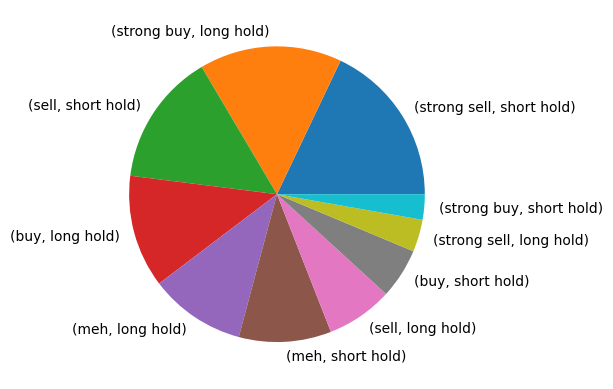

In [19]:
df[['pos_change_signal', 'net_pos_signal']].value_counts().plot(kind='pie')

In [23]:
df['daily_pnl'] = df['desired_pos_rolling'] * (df['close'] - df['open'])

<AxesSubplot:>

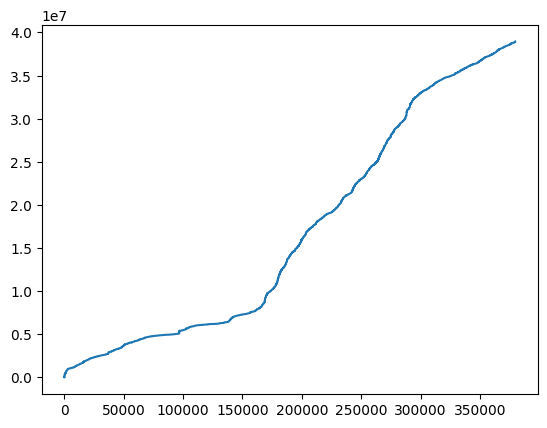

In [24]:
df.daily_pnl.cumsum().plot()

In [17]:
output = ta_map["SMA"](inputs)

In [18]:
output

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.56379035,
       0.56592234, 0.56354196, 0.56357981, 0.5759606 , 0.57891895,
       0.60568122, 0.6011442 , 0.58969133, 0.59014174, 0.57350315,
       0.57023573, 0.57325048, 0.59691296, 0.59028906, 0.58817202,
       0.6001237 , 0.62128806, 0.63327843, 0.64249598, 0.63900216,
       0.60932516, 0.61402808, 0.62876631, 0.62519055, 0.60609979,
       0.5998485 , 0.59959993, 0.6154019 , 0.59837884, 0.57913937,
       0.57113615, 0.57756787, 0.57938978, 0.56931161, 0.54834979,
       0.52476594, 0.51764841, 0.5154344 , 0.50179562, 0.5002672 ,
       0.50768852, 0.51649726, 0.49683872, 0.51526277, 0.51690

In [5]:
ta.RSI.parameters

AttributeError: 'function' object has no attribute 'parameters'

In [6]:
from talib import abstract

abstract.SMA.parameters

OrderedDict([('timeperiod', 30)])

In [2]:
df = pd.read_csv("data.csv")

In [3]:
generate_time_features(df)

In [5]:
df.datetime

0        2018-11-27 09:00:00
1        2018-11-27 09:01:00
2        2018-11-27 09:02:00
3        2018-11-27 09:03:00
4        2018-11-27 09:04:00
                 ...        
379720   2023-07-27 22:55:00
379721   2023-07-27 22:56:00
379722   2023-07-27 22:57:00
379723   2023-07-27 22:58:00
379724   2023-07-27 22:59:00
Name: datetime, Length: 379725, dtype: datetime64[ns]

In [5]:
with open("feature_names.txt", "r") as f:
    features = f.read()

In [2]:
import re

# Save this for production use!

In [11]:
with open("feature_names.txt", "r") as f:
    features = f.read()
feats = re.findall(r"(\w+\D)(\d+\b)", features)
func_pool = []

In [12]:
for func in feats:
    if func[0] == "MACDHIST" or func[0] == "MACDSIGNAL":
        continue
    if func[0] == "MACDSIGNALFIX" or func[0] == "MACDHISTFIX":
        continue
    if func[0] == "STOCHRSI_k" or func[0] == "STOCHRSI_d":
        continue
    if func[0] == "HT_PHASORinphase" or func[0] == "HT_PHASORquadrature":
        func[0] = "HT_PHASOR"
    if func[0] == "HT_SINEsine" or func[0] == "HT_SINEleadsine":
        func[0] = "HT_SINE"
    function = getattr(ta, func[0])
    func_pool.append((function, int(func[1])))

In [25]:
inspect.signature(func_pool[0][0])

ValueError: no signature found for builtin <built-in function ADOSC>

In [15]:
import inspect

In [17]:
for func, lag in func_pool:
    parameters = inspect.signature(func).parameters

ValueError: no signature found for builtin <built-in function ADOSC>

In [5]:
import talib as ta

In [8]:
getattr(ta, feats[0][0])

<function talib._ta_lib.ADOSC>